### Analisis de Localidad

In [47]:
import geopandas as gpd
from esda.moran import Moran
from libpysal.weights import Queen
import rasterio
from rasterio.plot import show
from rasterio.features import shapes

In [27]:
amenazas = gpd.read_file("../data/processed/amenazas/amenaza_valdivia.shp")

In [32]:
w = Queen.from_dataframe(amenazas)
moran = Moran(amenazas["gridcode"], w)

/tmp/ipykernel_5503/1739040107.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(amenazas)
/home/john/Documents/Universidad/Geoinformatica/firescope/.conda/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 58417.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 58417, ' is an island (no neighbors)')


In [37]:
print(f"I de Moran: {moran.I}, p-value: {moran.p_sim}")

I de Moran: 0.245773610545895, p-value: 0.001


In [49]:
src = rasterio.open("../data/processed/vegetacion_processed.tif")

In [50]:
resultados_formas = shapes(src.read(1), transform=src.transform)

# Crear GeoDataFrame
vegetacion = gpd.GeoDataFrame.from_features(
    [{'geometry': geom, 'properties': {'ndvi': val}} for geom, val in resultados_formas],
    crs=src.crs
)

In [52]:
w = Queen.from_dataframe(vegetacion)
moran = Moran(vegetacion["ndvi"], w)

/tmp/ipykernel_5503/2546796185.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(vegetacion)


In [54]:
print(f"I de Moran: {moran.I}, p-value: {moran.p_sim}")

I de Moran: 0.9077192790247997, p-value: 0.001


### Simulación

In [2]:
import moderngl
import numpy as np
import matplotlib.pyplot as plt

# Crea el contexto y el compute shader
ctx = moderngl.create_context(standalone=True)

compute = ctx.compute_shader(open("../src/shader/simular.glsl").read())

# Estados iniciales
estados = np.zeros((32, 32), dtype=np.int32)
estados[16, 0] = 1

# Genera los buffers para la simulación
buf_a = ctx.buffer(estados.tobytes())
buf_a.bind_to_storage_buffer(0)
buf_b = ctx.buffer(estados.tobytes())
buf_b.bind_to_storage_buffer(1)

# Ejecuta un paso en la simulación
def paso():
    global buf_a, buf_b
    buf_a.bind_to_storage_buffer(0)
    buf_b.bind_to_storage_buffer(1)

    compute.run(group_x=1, group_y=1)
    ctx.memory_barrier(moderngl.SHADER_STORAGE_BARRIER_BIT)
    buf_a, buf_b = buf_b, buf_a

#### Ejecución de paso a paso

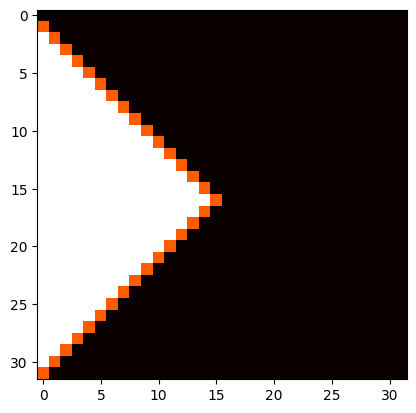

In [17]:
# Ejecuta un paso y muestra los resultados
paso()

result_a = np.frombuffer(buf_a.read(), dtype=np.int32)

plt.imshow(np.reshape(result_a, [32, -1]), vmin=0, vmax=2, interpolation='none', cmap="hot")